# Export detectron2 model to onnx format

A preliminary example of getting weights from detectron2 to onnx format. Its very hacky, but could easily be scriptable as a command line script.

TODO: Import class names from COCO segmentation and use the names in the final onnx model prediction.

TODO: Check whether the hardcoded '1344x1344' sample image dimension is really necessary.

Based upon instructions at https://medium.com/@frankvanpaassen3/how-to-optimize-custom-detectron2-models-with-tensorrt-2cd710954ad3
and:
 https://github.com/NVIDIA/TensorRT/tree/main/samples/python/detectron2#detectron-2-mask-r-cnn-r50-fpn-3x-in-tensorrt

### 1. Setup paths and variables

In [1]:
import os.path as osp

# Path to a .cfg file containing the detectron2 model parameters used for training
cfg_filename = './isaid_cfg.yaml'

# Path to a .pth file containing the fine-tuned weights from our detectron2 training
weights_filename = './model_final.pth'

# Path to a samle image to "anchor the model for conversion" (See the web pages linked above).
# This should come from the COCO dataset and have at least one classifiable object in it.
sample_image_filename = './sample.jpg'
# Set up a filename to resample the sample image to
rs_root, rs_ext = osp.splitext(sample_image_filename)
resample_image_filename = rs_root + '_rs' + rs_ext

# Do things on cpu or cuda? This seems quick enough on the cpu.
device = 'cpu'

# Set up an output path for the onnx model
output_path = './model.onnx'

### 2. Get the model config and weights in detectron2 format

Also verify the model does expected prediction on an example image.

The example image needs at least 1 detectable class for the 'tracing' method of model conversion.

/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


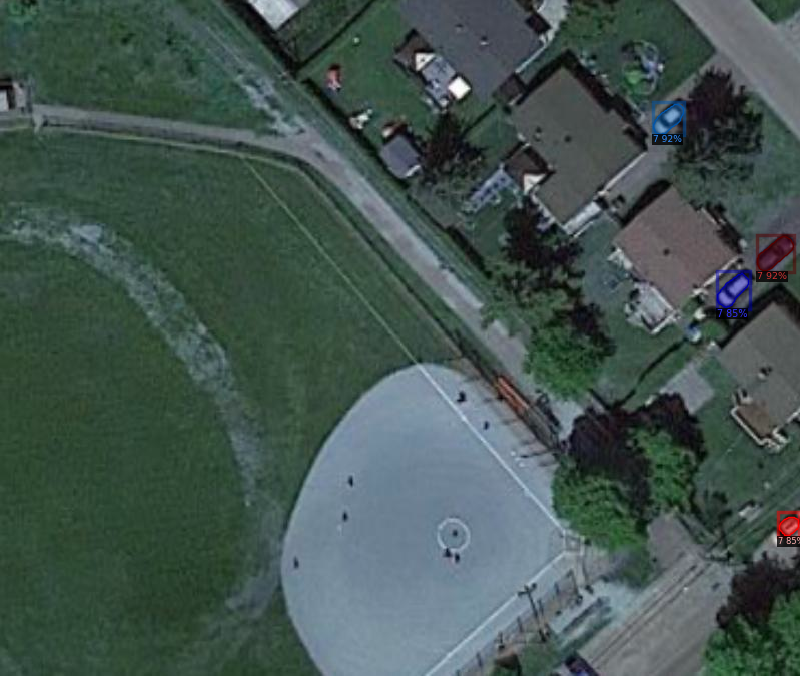

In [2]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from PIL import Image

# Look at the sample image and check that it has at least 1
# object detectable by the model.
# This is apparently required by the conversion to
# 'anchor the model' as described in the websites linked above.

# First load the input model and check that at least one class is predicted
# in the image.
cfg = get_cfg()
cfg.merge_from_file(cfg_filename)
cfg.MODEL.WEIGHTS = weights_filename  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.DEVICE = device
predictor = DefaultPredictor(cfg)

im1 = cv2.imread(sample_image_filename)
outputs = predictor(im1)
v = Visualizer(im1[:, :, ::-1])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

Image.fromarray(out.get_image()[:, :, ::-1])

### 3. Hack the 'export_model.py' script to work for us.

Also resize the sample image to the currently 1344x1344 size.

In [3]:
# This hack, as described in the websites linked in the header
# upon which this notebook is based may not actually be required since
# it refers to being required for TensorRT export after onnx export -
# but in the end we may want this anyhow so I'm leaving it in to see
# how it goes before I understand things better.

# Grab the detectron2 repo so we can hack and run the export_model.py script
!git clone https://github.com/facebookresearch/detectron2.git

# Need to hardcode sample_image size to 1344x1344 (must be multiple of 32)
export_script = open("./detectron2/tools/deploy/export_model.py", "r")
script_lines = export_script.readlines()
script_lines[165] = "    [1344, 1344], 1344 \n"

export_script = open("./export_model.py", "w")
export_script.writelines(script_lines)
export_script.close()

# Resample the sample_image to 1344x1344 as well
im2 = cv2.resize(im1, [1344, 1344])
cv2.imwrite(resample_image_filename, im2)

fatal: destination path 'detectron2' already exists and is not an empty directory.


True

### 4. Run the hacked export_model.py script to produce onnx model weights.

In [4]:
# Run our modified export_model script to get a model.onnx file
%run ./export_model.py \
--config-file $cfg_filename \
--output $output_path \
--format onnx \
--sample-image $resample_image_filename \
--export-method tracing \
MODEL.DEVICE $device MODEL.WEIGHTS $weights_filename


[09/15 11:26:28 detectron2]: Command line arguments: Namespace(format='onnx', export_method='tracing', config_file='./isaid_cfg.yaml', sample_image='./sample_rs.jpg', run_eval=False, output='./model.onnx', opts=['MODEL.DEVICE', 'cpu', 'MODEL.WEIGHTS', './model_final.pth'])


[W init.cpp:836] Warning: Use _jit_set_fusion_strategy, bailout depth is deprecated. Setting to (STATIC, 1) (function operator())


[09/15 11:26:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_final.pth ...


/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3.9/site-packages/detectron2/structures/image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3.9/site-packages/detectron2/structures/boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3.9/site-packages/detectron2/structures/boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might ca

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[09/15 11:26:34 detectron2]: Inputs schema: TupleSchema(schemas=[ListSchema(schemas=[DictSchema(schemas=[IdentitySchema()], sizes=[1], keys=['image'])], sizes=[1])], sizes=[1])
[09/15 11:26:34 detectron2]: Outputs schema: ListSchema(schemas=[DictSchema(schemas=[InstancesSchema(schemas=[TensorWrapSchema(class_name='detectron2.structures.Boxes'), IdentitySchema(), IdentitySchema(), IdentitySchema()], sizes=[1, 1, 1, 1], keys=['pred_boxes', 'pred_classes', 'pred_masks', 'scores'])], sizes=[5], keys=['instances'])], sizes=[5])
[09/15 11:26:34 detectron2]: Success.


### 5. Check the exported onnx model as a reasonale looking graph (optional)

In [5]:
# Now there should be an onnx model in onnx.model in the output dir
# Try and visualise the graph with netron (can take a bit of time to load)
import netron
import IPython

# Pick a port that isn't being used for browser display
port = 8081

# Read the model file and start the netron browser.
netron.start(osp.join(output_path, 'model.onnx'), port, browse=False)
IPython.display.IFrame(f"http://localhost:{port}", height=800, width=1000)

Serving './model.onnx/model.onnx' at http://localhost:8081


In [6]:
def preprocess(image):
    # Resize to currently hardcoded 1344x1344
    image = image.resize((1344, 1344))
    
    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Pad to be divisible of 32 - Might need this later on if I don't hardcode image size to 1344x1344
    #import math
    #padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    #padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    #padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    #padded_image[:, :image.shape[1], :image.shape[2]] = image
    #image = padded_image
    
    return image


### 6. Run prediction on test image using onnx model.

In [7]:
import numpy as np
import onnxruntime

session = onnxruntime.InferenceSession(osp.join(output_path, 'model.onnx'))

image = Image.open(sample_image_filename)

# Preprocess the image and convert to a numpy array of float:
# 1. reinterpolate it to the hardcoded size
# 2. reorder the colour axis as requires by the model (RGB -> BGR)
# 3. reorder the pixel/color array (YXC -> CXY)
img_data = preprocess(image)

# Predict using ONNX Runtime - throw away unneeded outputs (Still trying to work out what the extra outputs actually are)
boxes, labels, _, scores, _ = session.run(None, {
    session.get_inputs()[0].name: img_data
})
    

### 7. Display onnx predictions for comparison with detectron2 predictions.

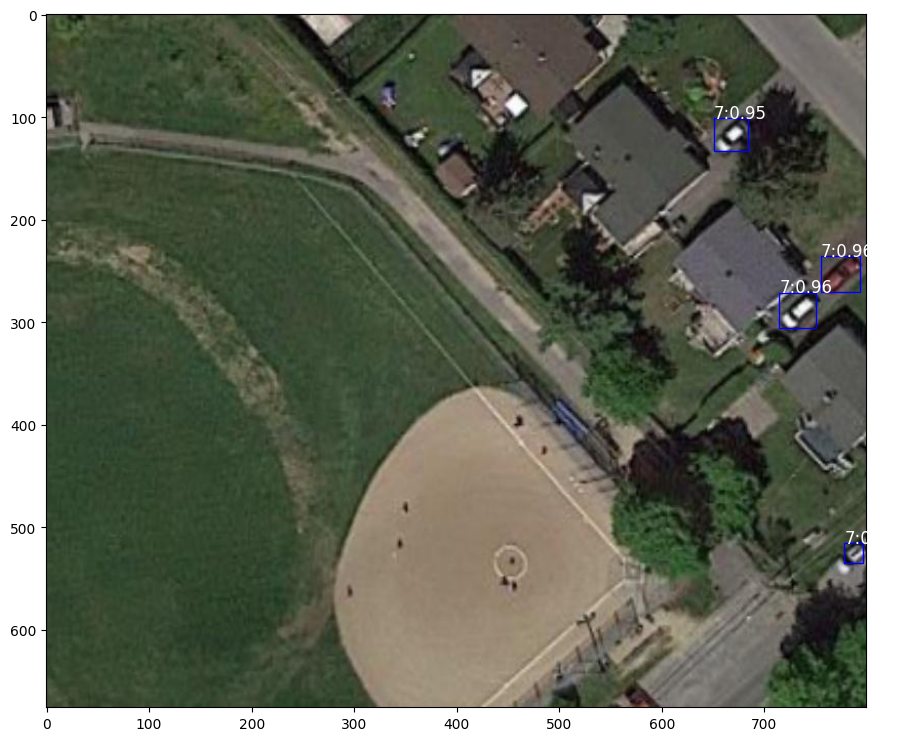

In [8]:
# Display the results (boxes with labels and scores overlaid on the image) using matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_objdetect_image(image, boxes, labels, scores, score_threshold=0.7):
    # Resize boxes to the original image size
    ratio = 1344.0 / np.array(image.size)
    boxes = boxes / np.tile(ratio, 2)[None, :]

    _, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(image)

    # Showing boxes with score > 0.7
    for box, label, score in zip(boxes, labels, scores):
        if score > score_threshold:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
            ax.annotate(str(label) + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=12)
            ax.add_patch(rect)
    plt.show()

display_objdetect_image(image, boxes, labels, scores)